# Keşifsel Veri Analizi (EDA) ve DBSCAN Kümeleme
## Türkiye Depremleri 1915-2025

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy import stats

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [41]:
kg = pd.read_excel("../data/cleaned/kaggle_cleaned_magnitude4.xlsx")
em = pd.read_excel("../data/cleaned/emdat_cleaned_final.xlsx")
merged = pd.read_excel("../data/merged/merged_all_matches.xlsx")

kg['Date'] = pd.to_datetime(kg['Date'])
em['Date'] = pd.to_datetime(em['Date'])
merged['Date'] = pd.to_datetime(merged['Date'])

print(f"Kaggle: {kg.shape}")
print(f"EM-DAT: {em.shape}")
print(f"Merged: {merged.shape}")

Kaggle: (5249, 14)
EM-DAT: (105, 6)
Merged: (65, 13)


## 1. Temel Istatistiksel Analizler

In [42]:
print("Kaggle Veri Seti Temel Istatistikler:")
kg[['Magnitude', 'Depth', 'Latitude', 'Longitude']].describe()

Kaggle Veri Seti Temel Istatistikler:


,Magnitude,Depth,Latitude,Longitude
count,5249.000000,5249.000000,5249.000000,5249.000000
mean,4.484016,21.277139,37.959712,32.596278
std,0.461669,25.059013,1.651647,5.964095
min,4.000000,1.000000,35.000000,26.000000
25%,4.100000,5.400000,36.600000,27.600000
50%,4.400000,10.000000,38.063200,29.700000
75%,4.700000,30.000000,39.090000,37.593800
max,7.500000,199.000000,41.960000,44.999200


In [43]:
print(f"Buyukluk Ortalamasi: {kg['Magnitude'].mean():.2f}")
print(f"Buyukluk Standart Sapma: {kg['Magnitude'].std():.2f}")
print(f"Buyukluk Medyani: {kg['Magnitude'].median():.2f}")
print(f"Buyukluk Modu: {kg['Magnitude'].mode().values[0]:.2f}")
print(f"Carpiklik (Skewness): {kg['Magnitude'].skew():.2f}")
print(f"Basiklik (Kurtosis): {kg['Magnitude'].kurtosis():.2f}")

Buyukluk Ortalamasi: 4.48
Buyukluk Standart Sapma: 0.46
Buyukluk Medyani: 4.40
Buyukluk Modu: 4.00
Carpiklik (Skewness): 1.49
Basiklik (Kurtosis): 3.33


In [44]:
print(f"Derinlik Ortalamasi: {kg['Depth'].mean():.2f} km")
print(f"Derinlik Standart Sapma: {kg['Depth'].std():.2f} km")
print(f"Derinlik Medyani: {kg['Depth'].median():.2f} km")
print(f"Minimum Derinlik: {kg['Depth'].min():.2f} km")
print(f"Maksimum Derinlik: {kg['Depth'].max():.2f} km")

Derinlik Ortalamasi: 21.28 km
Derinlik Standart Sapma: 25.06 km
Derinlik Medyani: 10.00 km
Minimum Derinlik: 1.00 km
Maksimum Derinlik: 199.00 km


In [45]:
percentiles = [25, 50, 75, 90, 95, 99]
print("Buyukluk Yuzdelik Dilimleri:")
for p in percentiles:
    print(f"  {p}. yuzdelik: {np.percentile(kg['Magnitude'], p):.2f}")

Buyukluk Yuzdelik Dilimleri:
  25. yuzdelik: 4.10
  50. yuzdelik: 4.40
  75. yuzdelik: 4.70
  90. yuzdelik: 5.10
  95. yuzdelik: 5.30
  99. yuzdelik: 6.00


## 2. Veri Dagilimlari

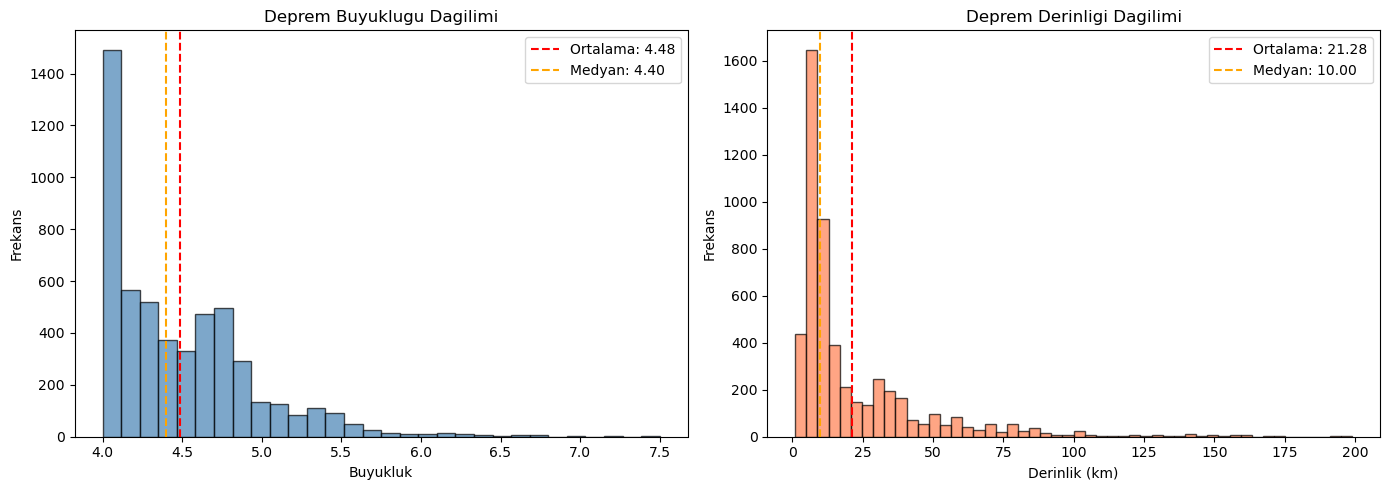

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(kg['Magnitude'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(kg['Magnitude'].mean(), color='red', linestyle='--', label=f'Ortalama: {kg["Magnitude"].mean():.2f}')
axes[0].axvline(kg['Magnitude'].median(), color='orange', linestyle='--', label=f'Medyan: {kg["Magnitude"].median():.2f}')
axes[0].set_xlabel('Buyukluk')
axes[0].set_ylabel('Frekans')
axes[0].set_title('Deprem Buyuklugu Dagilimi')
axes[0].legend()

axes[1].hist(kg['Depth'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(kg['Depth'].mean(), color='red', linestyle='--', label=f'Ortalama: {kg["Depth"].mean():.2f}')
axes[1].axvline(kg['Depth'].median(), color='orange', linestyle='--', label=f'Medyan: {kg["Depth"].median():.2f}')
axes[1].set_xlabel('Derinlik (km)')
axes[1].set_ylabel('Frekans')
axes[1].set_title('Deprem Derinligi Dagilimi')
axes[1].legend()

plt.tight_layout()
plt.savefig('../outputs/01_magnitude_depth_distribution.png', dpi=150)
plt.show()

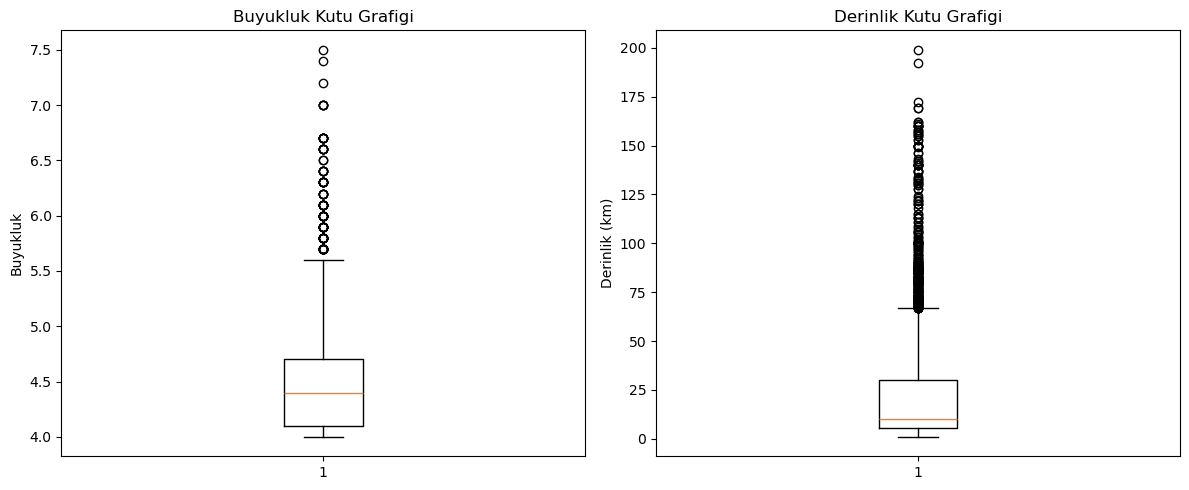

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].boxplot(kg['Magnitude'], vert=True)
axes[0].set_ylabel('Buyukluk')
axes[0].set_title('Buyukluk Kutu Grafigi')

axes[1].boxplot(kg['Depth'], vert=True)
axes[1].set_ylabel('Derinlik (km)')
axes[1].set_title('Derinlik Kutu Grafigi')

plt.tight_layout()
plt.savefig('../outputs/02_boxplots.png', dpi=150)
plt.show()

In [48]:
def categorize_magnitude(m):
    if m < 4.5:
        return 'Hafif (4.0-4.4)'
    elif m < 5.0:
        return 'Orta (4.5-4.9)'
    elif m < 6.0:
        return 'Guclu (5.0-5.9)'
    elif m < 7.0:
        return 'Buyuk (6.0-6.9)'
    else:
        return 'Major (7.0+)'

kg['Magnitude_Category'] = kg['Magnitude'].apply(categorize_magnitude)

category_counts = kg['Magnitude_Category'].value_counts()
print("Buyukluk Kategorileri:")
print(category_counts)
print(f"\nYuzdelik Dagilim:")
print((category_counts / len(kg) * 100).round(2))

Buyukluk Kategorileri:
Magnitude_Category
Hafif (4.0-4.4)    2949
Orta (4.5-4.9)     1588
Guclu (5.0-5.9)     649
Buyuk (6.0-6.9)      56
Major (7.0+)          7
Name: count, dtype: int64

Yuzdelik Dagilim:
Magnitude_Category
Hafif (4.0-4.4)    56.18
Orta (4.5-4.9)     30.25
Guclu (5.0-5.9)    12.36
Buyuk (6.0-6.9)     1.07
Major (7.0+)        0.13
Name: count, dtype: float64


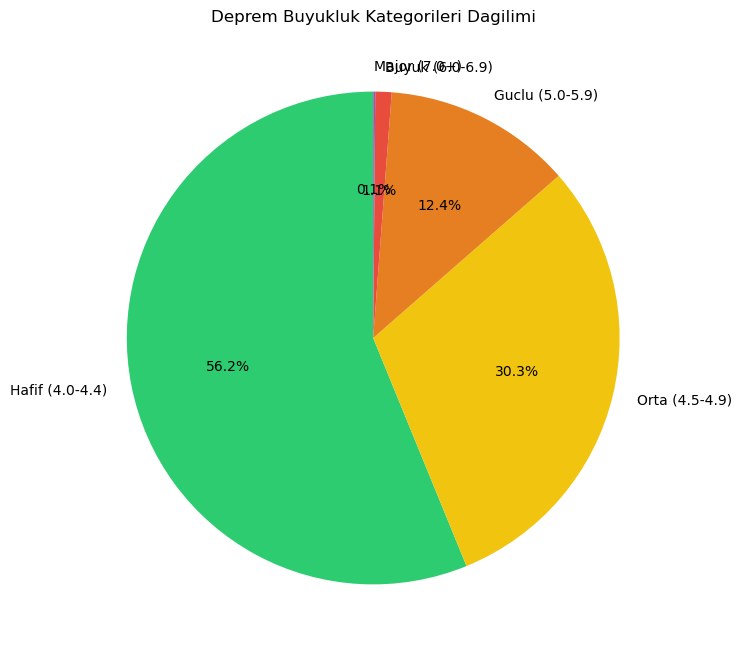

In [49]:
order = ['Hafif (4.0-4.4)', 'Orta (4.5-4.9)', 'Guclu (5.0-5.9)', 'Buyuk (6.0-6.9)', 'Major (7.0+)']
category_counts_ordered = category_counts.reindex(order)

plt.figure(figsize=(10, 8))
colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c', '#9b59b6']
plt.pie(category_counts_ordered, labels=category_counts_ordered.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Deprem Buyukluk Kategorileri Dagilimi')
plt.savefig('../outputs/03_magnitude_categories_pie.png', dpi=150)
plt.show()

## 3. Zamansal Analiz

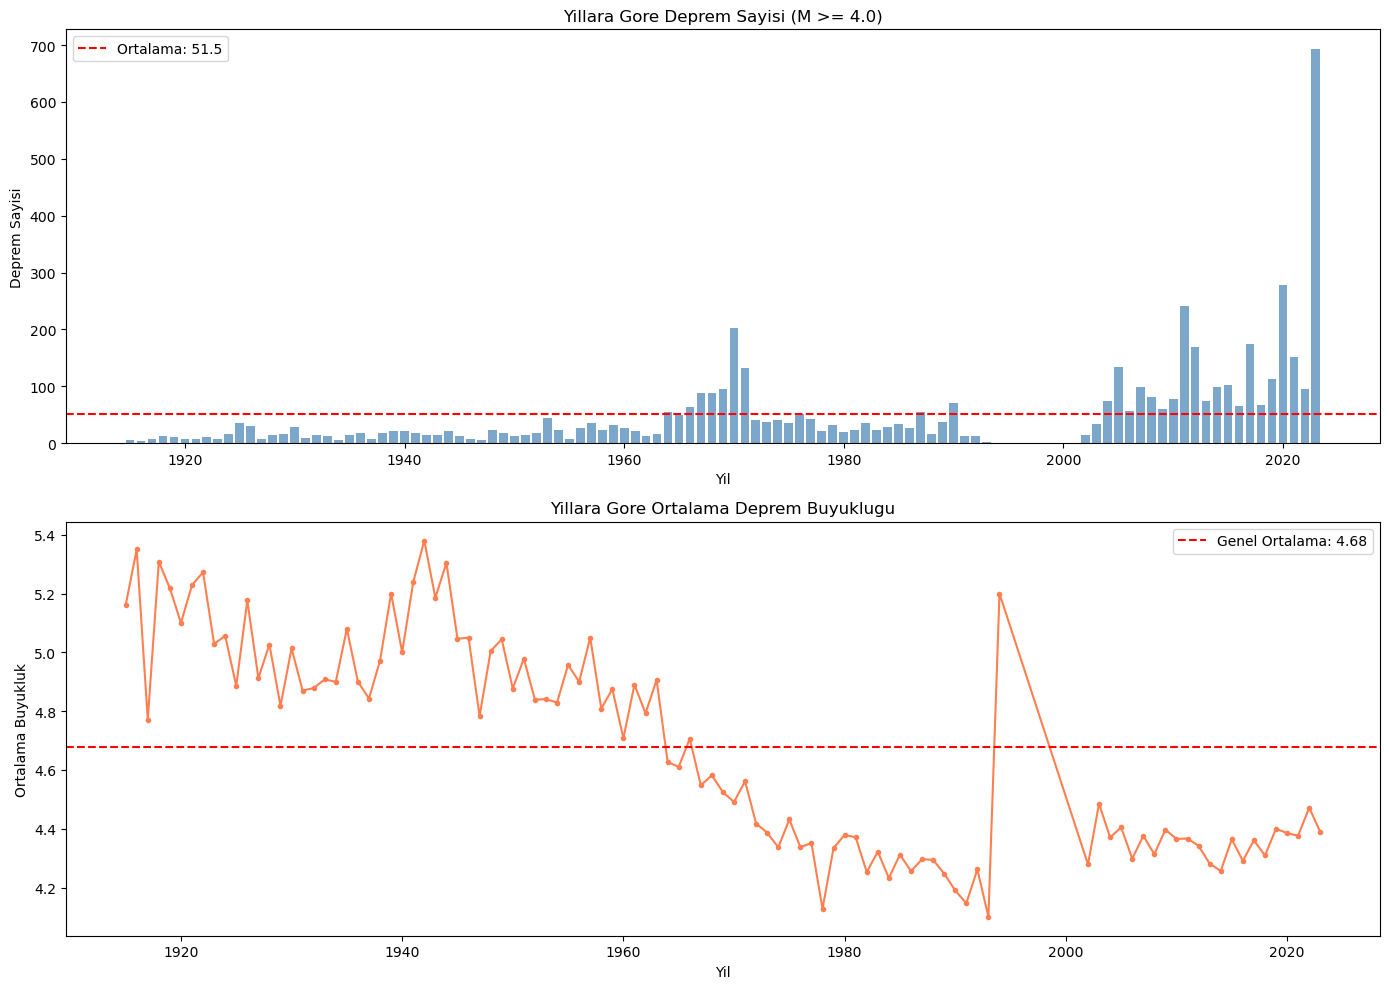

In [50]:
kg['Year'] = kg['Date'].dt.year
yearly_counts = kg.groupby('Year').size()
yearly_mean_mag = kg.groupby('Year')['Magnitude'].mean()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].bar(yearly_counts.index, yearly_counts.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Yil')
axes[0].set_ylabel('Deprem Sayisi')
axes[0].set_title('Yillara Gore Deprem Sayisi (M >= 4.0)')
axes[0].axhline(yearly_counts.mean(), color='red', linestyle='--', label=f'Ortalama: {yearly_counts.mean():.1f}')
axes[0].legend()

axes[1].plot(yearly_mean_mag.index, yearly_mean_mag.values, color='coral', marker='o', markersize=3)
axes[1].set_xlabel('Yil')
axes[1].set_ylabel('Ortalama Buyukluk')
axes[1].set_title('Yillara Gore Ortalama Deprem Buyuklugu')
axes[1].axhline(yearly_mean_mag.mean(), color='red', linestyle='--', label=f'Genel Ortalama: {yearly_mean_mag.mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('../outputs/04_yearly_analysis.png', dpi=150)
plt.show()

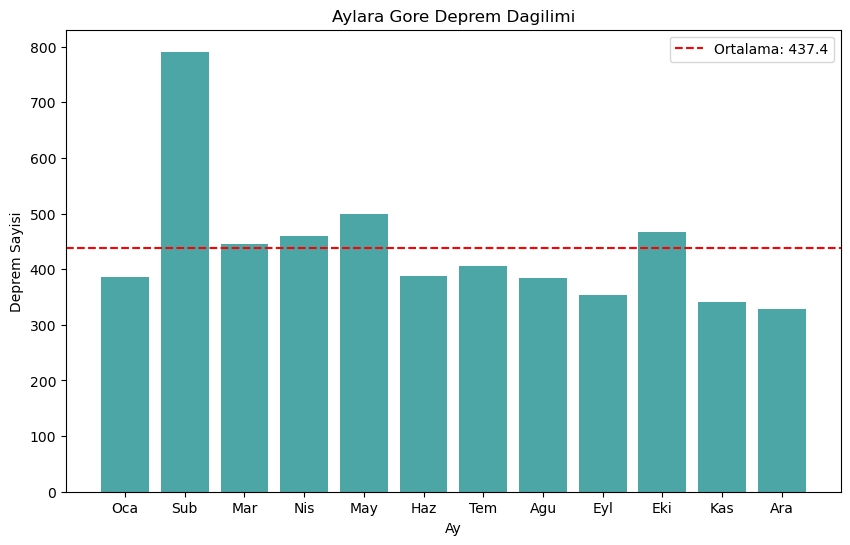

In [51]:
kg['Month'] = kg['Date'].dt.month
monthly_counts = kg.groupby('Month').size()

month_names = ['Oca', 'Sub', 'Mar', 'Nis', 'May', 'Haz', 'Tem', 'Agu', 'Eyl', 'Eki', 'Kas', 'Ara']

plt.figure(figsize=(10, 6))
plt.bar(range(1, 13), monthly_counts.values, color='teal', alpha=0.7)
plt.xticks(range(1, 13), month_names)
plt.xlabel('Ay')
plt.ylabel('Deprem Sayisi')
plt.title('Aylara Gore Deprem Dagilimi')
plt.axhline(monthly_counts.mean(), color='red', linestyle='--', label=f'Ortalama: {monthly_counts.mean():.1f}')
plt.legend()
plt.savefig('../outputs/05_monthly_distribution.png', dpi=150)
plt.show()

In [52]:
kg['Decade'] = (kg['Year'] // 10) * 10
decade_stats = kg.groupby('Decade').agg({
    'Magnitude': ['count', 'mean', 'max'],
    'Depth': 'mean'
}).round(2)
decade_stats.columns = ['Deprem_Sayisi', 'Ort_Buyukluk', 'Max_Buyukluk', 'Ort_Derinlik']
print("On Yillara Gore Istatistikler:")
decade_stats

On Yillara Gore Istatistikler:


,Deprem_Sayisi,Ort_Buyukluk,Max_Buyukluk,Ort_Derinlik
Decade,,,,
1910,39,5.17,6.6,21.69
1920,153,5.03,7.0,26.05
1930,150,4.98,7.2,36.27
1940,158,5.13,6.7,38.23
1950,238,4.89,6.7,36.41
1960,516,4.62,7.0,39.84
1970,636,4.44,7.0,31.27
1980,300,4.29,5.9,30.35
1990,100,4.20,5.7,22.70


## 4. Korelasyon Analizleri

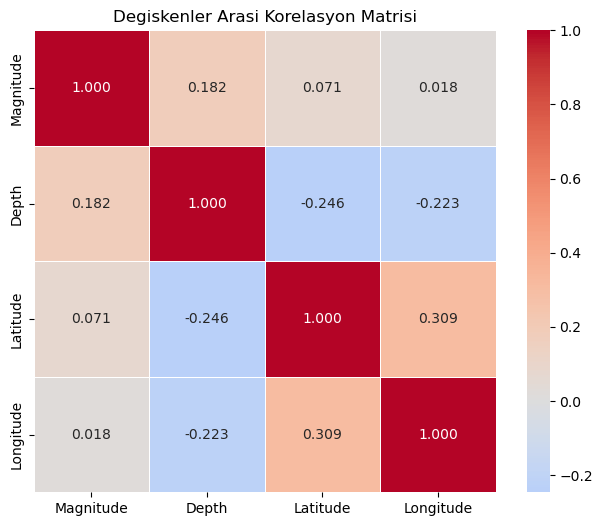

In [53]:
correlation_cols = ['Magnitude', 'Depth', 'Latitude', 'Longitude']
corr_matrix = kg[correlation_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f',
            square=True, linewidths=0.5)
plt.title('Degiskenler Arasi Korelasyon Matrisi')
plt.savefig('../outputs/06_correlation_matrix.png', dpi=150)
plt.show()

In [54]:
corr_coef, p_value = stats.pearsonr(kg['Magnitude'], kg['Depth'])
print(f"Buyukluk-Derinlik Pearson Korelasyonu: {corr_coef:.4f}")
print(f"P-degeri: {p_value:.4e}")

spearman_corr, spearman_p = stats.spearmanr(kg['Magnitude'], kg['Depth'])
print(f"Buyukluk-Derinlik Spearman Korelasyonu: {spearman_corr:.4f}")
print(f"P-degeri: {spearman_p:.4e}")

Buyukluk-Derinlik Pearson Korelasyonu: 0.1818
P-degeri: 3.1285e-40
Buyukluk-Derinlik Spearman Korelasyonu: 0.2749
P-degeri: 1.1788e-91


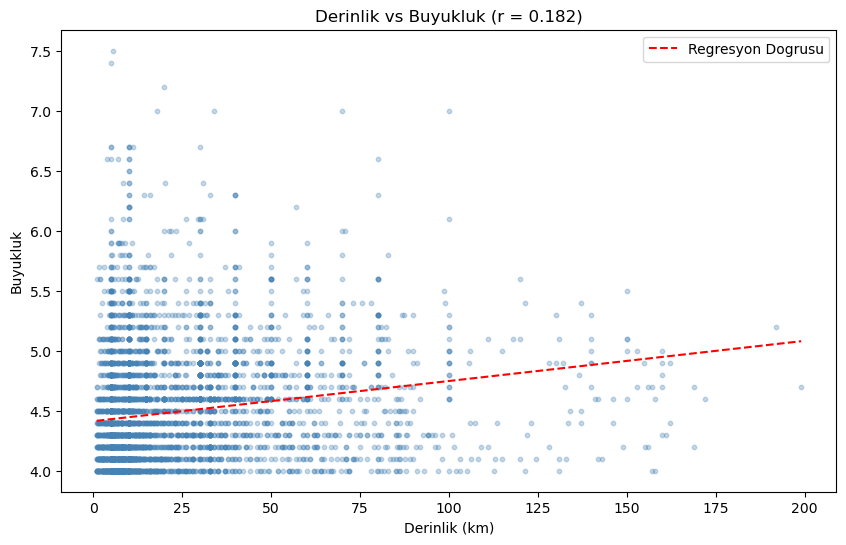

In [55]:
plt.figure(figsize=(10, 6))
plt.scatter(kg['Depth'], kg['Magnitude'], alpha=0.3, s=10, c='steelblue')
plt.xlabel('Derinlik (km)')
plt.ylabel('Buyukluk')
plt.title(f'Derinlik vs Buyukluk (r = {corr_coef:.3f})')

z = np.polyfit(kg['Depth'], kg['Magnitude'], 1)
p = np.poly1d(z)
x_line = np.linspace(kg['Depth'].min(), kg['Depth'].max(), 100)
plt.plot(x_line, p(x_line), 'r--', label='Regresyon Dogrusu')
plt.legend()
plt.savefig('../outputs/07_depth_magnitude_scatter.png', dpi=150)
plt.show()

## 5. Buyukluk - Insan Etkisi Korelasyonu (1960 Sonrasi)

In [56]:
merged['Year'] = merged['Date'].dt.year
merged_post1960 = merged[merged['Year'] >= 1960].copy()
merged_post1960 = merged_post1960[merged_post1960['Total_Deaths'] > 0]

print(f"1960 Sonrasi Olumlu Deprem Sayisi: {len(merged_post1960)}")
print(f"Toplam Olum Sayisi: {merged_post1960['Total_Deaths'].sum():.0f}")

1960 Sonrasi Olumlu Deprem Sayisi: 25
Toplam Olum Sayisi: 57663


In [57]:
print("1960 Sonrasi Olum Istatistikleri:")
print(f"Ortalama Olum: {merged_post1960['Total_Deaths'].mean():.1f}")
print(f"Medyan Olum: {merged_post1960['Total_Deaths'].median():.1f}")
print(f"Maksimum Olum: {merged_post1960['Total_Deaths'].max():.0f}")
print(f"Standart Sapma: {merged_post1960['Total_Deaths'].std():.1f}")

1960 Sonrasi Olum Istatistikleri:
Ortalama Olum: 2306.5
Medyan Olum: 23.0
Maksimum Olum: 53000
Standart Sapma: 10573.8


In [58]:
if len(merged_post1960) >= 3:
    corr_mag_death, p_mag_death = stats.pearsonr(merged_post1960['Magnitude'], merged_post1960['Total_Deaths'])
    print(f"Buyukluk-Olum Pearson Korelasyonu: {corr_mag_death:.4f}")
    print(f"P-degeri: {p_mag_death:.4e}")
    
    spearman_mag_death, sp_p = stats.spearmanr(merged_post1960['Magnitude'], merged_post1960['Total_Deaths'])
    print(f"Buyukluk-Olum Spearman Korelasyonu: {spearman_mag_death:.4f}")
    print(f"P-degeri: {sp_p:.4e}")
    
    merged_post1960['Log_Deaths'] = np.log1p(merged_post1960['Total_Deaths'])
    corr_log, p_log = stats.pearsonr(merged_post1960['Magnitude'], merged_post1960['Log_Deaths'])
    print(f"Buyukluk-Log(Olum) Pearson Korelasyonu: {corr_log:.4f}")
else:
    print("Yetersiz veri")

Buyukluk-Olum Pearson Korelasyonu: 0.4547
P-degeri: 2.2391e-02
Buyukluk-Olum Spearman Korelasyonu: 0.4759
P-degeri: 1.6198e-02
Buyukluk-Log(Olum) Pearson Korelasyonu: 0.6028


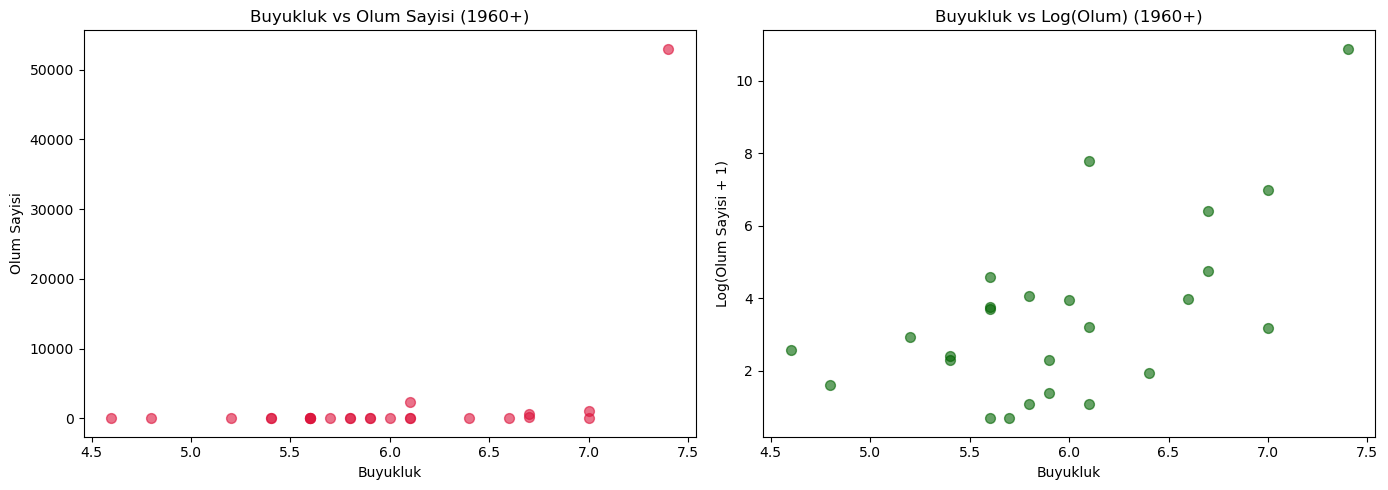

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(merged_post1960['Magnitude'], merged_post1960['Total_Deaths'], 
                alpha=0.6, s=50, c='crimson')
axes[0].set_xlabel('Buyukluk')
axes[0].set_ylabel('Olum Sayisi')
axes[0].set_title('Buyukluk vs Olum Sayisi (1960+)')

axes[1].scatter(merged_post1960['Magnitude'], merged_post1960['Log_Deaths'], 
                alpha=0.6, s=50, c='darkgreen')
axes[1].set_xlabel('Buyukluk')
axes[1].set_ylabel('Log(Olum Sayisi + 1)')
axes[1].set_title('Buyukluk vs Log(Olum) (1960+)')

plt.tight_layout()
plt.savefig('../outputs/08_magnitude_deaths_correlation.png', dpi=150)
plt.show()

In [60]:
if len(merged_post1960) >= 3:
    corr_depth_death, p_depth = stats.pearsonr(merged_post1960['Depth'], merged_post1960['Total_Deaths'])
    print(f"Derinlik-Olum Pearson Korelasyonu: {corr_depth_death:.4f}")
    print(f"P-degeri: {p_depth:.4e}")

Derinlik-Olum Pearson Korelasyonu: -0.1887
P-degeri: 3.6628e-01


In [61]:
print("En Olumcul 10 Deprem (1960+):")
top_deadly = merged_post1960.nlargest(10, 'Total_Deaths')[['Date', 'Magnitude', 'Depth', 'EMDAT_Location', 'Total_Deaths']]
top_deadly

En Olumcul 10 Deprem (1960+):


,Date,Magnitude,Depth,EMDAT_Location,Total_Deaths
63,2023-02-06,7.4,5.0,ADANA,53000
34,1966-08-19,6.1,26.0,VARTO,2394
38,1970-03-28,7.0,18.0,GEDIZ,1086
55,2011-10-23,6.7,5.0,BITLIS,604
61,2020-10-30,6.7,11.2,IZMIR,115
35,1967-07-26,5.6,30.0,TUNCELI,97
40,1971-05-12,5.8,30.0,BURDUR,57
37,1969-03-28,6.6,4.0,"WEST ALASEHIR, SARIGOL, KIRZ",53
53,2010-03-08,6.0,5.0,ELAZIG,51
44,2002-02-03,5.6,10.0,BOLVADIN DISTRICT (AFYON PROVINCE),42


## 6. Bolgesel Analiz

In [62]:
location_stats = kg.groupby('Location_clean').agg({
    'Magnitude': ['count', 'mean', 'max'],
    'Depth': 'mean'
}).round(2)
location_stats.columns = ['Deprem_Sayisi', 'Ort_Buyukluk', 'Max_Buyukluk', 'Ort_Derinlik']
location_stats = location_stats.sort_values('Deprem_Sayisi', ascending=False)

print("En Cok Deprem Olan 15 Bolge:")
location_stats.head(15)

En Cok Deprem Olan 15 Bolge:


,Deprem_Sayisi,Ort_Buyukluk,Max_Buyukluk,Ort_Derinlik
Location_clean,,,,
AKDENIZ,1005,4.47,6.7,35.90
VAN,296,4.37,6.7,9.11
KAHRAMANMARAS,280,4.37,7.4,6.25
MUGLA,207,4.49,6.1,27.43
MALATYA,179,4.46,5.8,7.80
MANISA,159,4.43,6.6,15.49
IZMIR,142,4.41,6.2,16.56
ONIKI ADALAR (AKDENIZ),127,4.47,7.0,38.70
DENIZLI,106,4.54,5.8,18.43


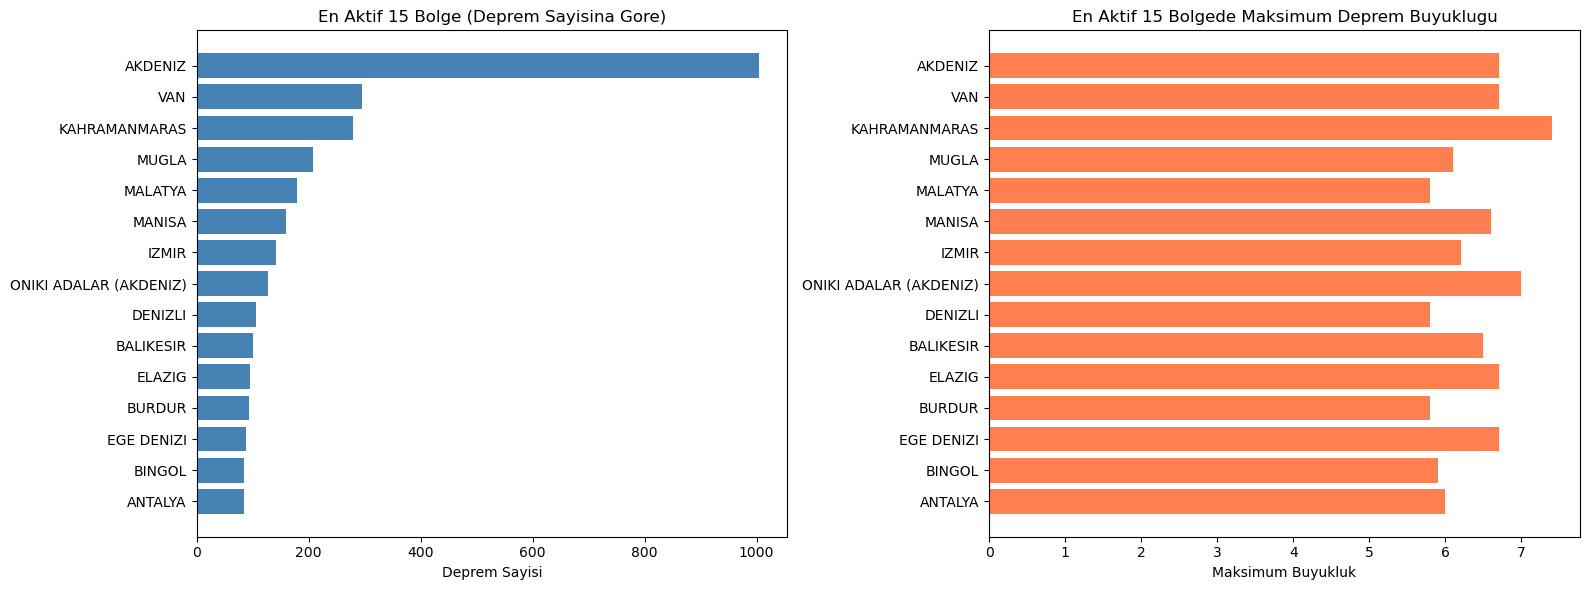

In [63]:
top15 = location_stats.head(15)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(top15.index[::-1], top15['Deprem_Sayisi'][::-1], color='steelblue')
axes[0].set_xlabel('Deprem Sayisi')
axes[0].set_title('En Aktif 15 Bolge (Deprem Sayisina Gore)')

axes[1].barh(top15.index[::-1], top15['Max_Buyukluk'][::-1], color='coral')
axes[1].set_xlabel('Maksimum Buyukluk')
axes[1].set_title('En Aktif 15 Bolgede Maksimum Deprem Buyuklugu')

plt.tight_layout()
plt.savefig('../outputs/09_regional_analysis.png', dpi=150)
plt.show()

In [64]:
min_earthquakes = 20
frequent_regions = location_stats[location_stats['Deprem_Sayisi'] >= min_earthquakes].copy()
frequent_regions['Risk_Score'] = (
    frequent_regions['Deprem_Sayisi'] * 0.3 +
    frequent_regions['Ort_Buyukluk'] * 10 +
    frequent_regions['Max_Buyukluk'] * 5 -
    frequent_regions['Ort_Derinlik'] * 0.1
).round(2)
frequent_regions = frequent_regions.sort_values('Risk_Score', ascending=False)

print("Yuksek Riskli Bolgeler (Risk Skoruna Gore):")
frequent_regions.head(15)

Yuksek Riskli Bolgeler (Risk Skoruna Gore):


,Deprem_Sayisi,Ort_Buyukluk,Max_Buyukluk,Ort_Derinlik,Risk_Score
Location_clean,,,,,
AKDENIZ,1005,4.47,6.7,35.90,376.11
VAN,296,4.37,6.7,9.11,165.09
KAHRAMANMARAS,280,4.37,7.4,6.25,164.08
MUGLA,207,4.49,6.1,27.43,134.76
MALATYA,179,4.46,5.8,7.80,126.52
MANISA,159,4.43,6.6,15.49,123.45
IZMIR,142,4.41,6.2,16.56,116.04
ONIKI ADALAR (AKDENIZ),127,4.47,7.0,38.70,113.93
ELAZIG,95,4.52,6.7,8.65,106.34


## 7. DBSCAN Kumeleme Analizi

In [65]:
clustering_data = kg[['Latitude', 'Longitude', 'Magnitude', 'Depth']].dropna()
print(f"Kumeleme icin kullanilacak veri sayisi: {len(clustering_data)}")

Kumeleme icin kullanilacak veri sayisi: 5249


In [66]:
geo_data = clustering_data[['Latitude', 'Longitude']].values

eps_km = 50
eps_deg = eps_km / 111

dbscan_geo = DBSCAN(eps=eps_deg, min_samples=10)
geo_clusters = dbscan_geo.fit_predict(geo_data)

clustering_data = clustering_data.copy()
clustering_data['Geo_Cluster'] = geo_clusters

n_clusters_geo = len(set(geo_clusters)) - (1 if -1 in geo_clusters else 0)
n_noise_geo = list(geo_clusters).count(-1)

print(f"Cografi Kume Sayisi: {n_clusters_geo}")
print(f"Gurultu Noktasi Sayisi: {n_noise_geo}")
print(f"Gurultu Orani: {n_noise_geo/len(clustering_data)*100:.2f}%")

Cografi Kume Sayisi: 10
Gurultu Noktasi Sayisi: 166
Gurultu Orani: 3.16%


In [67]:
# Kumelerin hangi bolgeleri temsil ettigini belirleme
# Bu kodu notebook'a ekleyebilirsin

import pandas as pd
import numpy as np

# Veriyi yukle
kg = pd.read_excel("../data/cleaned/kaggle_cleaned_magnitude4.xlsx")
kg['Date'] = pd.to_datetime(kg['Date'])

# DBSCAN icin hazirlik
from sklearn.cluster import DBSCAN

clustering_data = kg[['Latitude', 'Longitude', 'Magnitude', 'Depth', 'Location_clean']].dropna()
geo_data = clustering_data[['Latitude', 'Longitude']].values

eps_km = 50
eps_deg = eps_km / 111

dbscan_geo = DBSCAN(eps=eps_deg, min_samples=10)
geo_clusters = dbscan_geo.fit_predict(geo_data)

clustering_data = clustering_data.copy()
clustering_data['Geo_Cluster'] = geo_clusters

# Her kume icin bolge dagilimini hesapla
def get_cluster_regions(cluster_id):
    cluster_data = clustering_data[clustering_data['Geo_Cluster'] == cluster_id]
    
    region_counts = cluster_data['Location_clean'].value_counts()
    top_regions = region_counts.head(5)
    
    center_lat = cluster_data['Latitude'].mean()
    center_lon = cluster_data['Longitude'].mean()
    
    return {
        'Cluster_ID': cluster_id,
        'Deprem_Sayisi': len(cluster_data),
        'Merkez_Enlem': round(center_lat, 3),
        'Merkez_Boylam': round(center_lon, 3),
        'Ana_Bolge': top_regions.index[0] if len(top_regions) > 0 else 'Bilinmiyor',
        'Ana_Bolge_Yuzdesi': round(top_regions.iloc[0] / len(cluster_data) * 100, 1) if len(top_regions) > 0 else 0,
        'Diger_Bolgeler': ', '.join(top_regions.index[1:4].tolist()) if len(top_regions) > 1 else '-'
    }

# Tum kumeleri analiz et
cluster_ids = sorted([c for c in clustering_data['Geo_Cluster'].unique() if c != -1])

cluster_regions = []
for cid in cluster_ids:
    cluster_regions.append(get_cluster_regions(cid))

cluster_df = pd.DataFrame(cluster_regions)
cluster_df = cluster_df.sort_values('Deprem_Sayisi', ascending=False)

print("="*80)
print("DBSCAN KUMELERI VE TEMSIL ETTIKLERI BOLGELER")
print("="*80)
print(f"\nToplam Kume Sayisi: {len(cluster_ids)}")
print(f"Kumelenmis Deprem Sayisi: {len(clustering_data[clustering_data['Geo_Cluster'] != -1])}")
print(f"Gurultu (Kumelenmemis): {len(clustering_data[clustering_data['Geo_Cluster'] == -1])}")
print("\n")

for _, row in cluster_df.iterrows():
    print(f"KUME {int(row['Cluster_ID'])}:")
    print(f"  Deprem Sayisi: {row['Deprem_Sayisi']}")
    print(f"  Merkez Koordinat: ({row['Merkez_Enlem']}, {row['Merkez_Boylam']})")
    print(f"  Ana Bolge: {row['Ana_Bolge']} (%{row['Ana_Bolge_Yuzdesi']})")
    print(f"  Diger Bolgeler: {row['Diger_Bolgeler']}")
    print()

# Turkiye fay hatlari ile iliskili yorumlama
print("="*80)
print("JEOLOJIK YORUM")
print("="*80)

fay_hatlari = {
    'Kuzey Anadolu Fay Hatti': {'lat_range': (39.5, 41.5), 'lon_range': (26, 42)},
    'Dogu Anadolu Fay Hatti': {'lat_range': (36.5, 39.5), 'lon_range': (35, 42)},
    'Bati Anadolu Graben Sistemi': {'lat_range': (37, 39), 'lon_range': (27, 31)},
    'Ege Denizi Fay Zonlari': {'lat_range': (37, 40), 'lon_range': (25, 28)},
    'Akdeniz-Kibris Yay': {'lat_range': (35.5, 37), 'lon_range': (28, 36)}
}

for _, row in cluster_df.iterrows():
    lat, lon = row['Merkez_Enlem'], row['Merkez_Boylam']
    
    iliskili_faylar = []
    for fay_adi, coords in fay_hatlari.items():
        lat_min, lat_max = coords['lat_range']
        lon_min, lon_max = coords['lon_range']
        
        if lat_min <= lat <= lat_max and lon_min <= lon <= lon_max:
            iliskili_faylar.append(fay_adi)
    
    if iliskili_faylar:
        print(f"Kume {int(row['Cluster_ID'])} ({row['Ana_Bolge']}): {', '.join(iliskili_faylar)}")

# CSV olarak kaydet
cluster_df.to_csv('../outputs/cluster_region_mapping.csv', index=False)
print("\nSonuclar 'cluster_region_mapping.csv' olarak kaydedildi.")

DBSCAN KUMELERI VE TEMSIL ETTIKLERI BOLGELER

Toplam Kume Sayisi: 10
Kumelenmis Deprem Sayisi: 5083
Gurultu (Kumelenmemis): 166


KUME 1:
  Deprem Sayisi: 3141
  Merkez Koordinat: (37.561, 28.154)
  Ana Bolge: AKDENIZ (%31.5)
  Diger Bolgeler: MUGLA, MANISA, IZMIR

KUME 0:
  Deprem Sayisi: 1661
  Merkez Koordinat: (38.302, 39.804)
  Ana Bolge: VAN (%17.8)
  Diger Bolgeler: KAHRAMANMARAS, MALATYA, ELAZIG

KUME 2:
  Deprem Sayisi: 138
  Merkez Koordinat: (40.434, 33.528)
  Ana Bolge: ANKARA (%23.9)
  Diger Bolgeler: KASTAMONU, CANKIRI, CORUM

KUME 3:
  Deprem Sayisi: 64
  Merkez Koordinat: (41.289, 43.996)
  Ana Bolge: AZERBAYCAN (%37.5)
  Diger Bolgeler: GÜRCISTAN, ERMENISTAN, GURCISTAN

KUME 5:
  Deprem Sayisi: 21
  Merkez Koordinat: (40.56, 36.902)
  Ana Bolge: TOKAT (%71.4)
  Diger Bolgeler: ORDU, MUS, AMASYA

KUME 4:
  Deprem Sayisi: 16
  Merkez Koordinat: (38.954, 35.739)
  Ana Bolge: KAYSERI (%81.2)
  Diger Bolgeler: SIVAS

KUME 6:
  Deprem Sayisi: 15
  Merkez Koordinat: (36.086, 

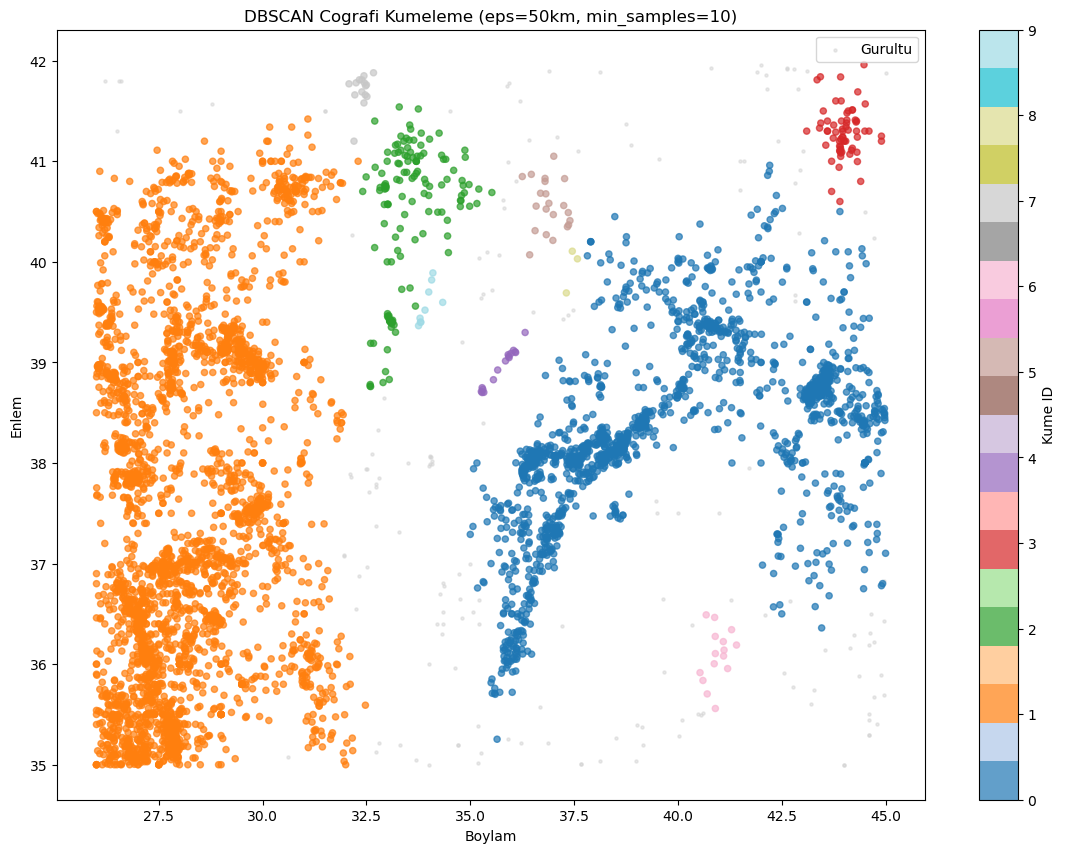

In [68]:
plt.figure(figsize=(14, 10))

noise_mask = clustering_data['Geo_Cluster'] == -1
plt.scatter(clustering_data.loc[noise_mask, 'Longitude'], 
            clustering_data.loc[noise_mask, 'Latitude'],
            c='lightgray', s=5, alpha=0.5, label='Gurultu')

clustered_mask = clustering_data['Geo_Cluster'] != -1
scatter = plt.scatter(clustering_data.loc[clustered_mask, 'Longitude'], 
                      clustering_data.loc[clustered_mask, 'Latitude'],
                      c=clustering_data.loc[clustered_mask, 'Geo_Cluster'],
                      cmap='tab20', s=20, alpha=0.7)

plt.colorbar(scatter, label='Kume ID')
plt.xlabel('Boylam')
plt.ylabel('Enlem')
plt.title(f'DBSCAN Cografi Kumeleme (eps={eps_km}km, min_samples=10)')
plt.legend()
plt.savefig('../outputs/10_dbscan_geographic_clusters.png', dpi=150)
plt.show()

In [69]:
cluster_stats = clustering_data[clustering_data['Geo_Cluster'] != -1].groupby('Geo_Cluster').agg({
    'Latitude': ['mean', 'count'],
    'Longitude': 'mean',
    'Magnitude': ['mean', 'max'],
    'Depth': 'mean'
}).round(3)
cluster_stats.columns = ['Ort_Enlem', 'Deprem_Sayisi', 'Ort_Boylam', 'Ort_Buyukluk', 'Max_Buyukluk', 'Ort_Derinlik']
cluster_stats = cluster_stats.sort_values('Deprem_Sayisi', ascending=False)

print("Kume Istatistikleri:")
cluster_stats.head(20)

Kume Istatistikleri:


,Ort_Enlem,Deprem_Sayisi,Ort_Boylam,Ort_Buyukluk,Max_Buyukluk,Ort_Derinlik
Geo_Cluster,,,,,,
1,37.561,3141,28.154,4.479,7.0,26.333
0,38.302,1661,39.804,4.456,7.5,12.243
2,40.434,138,33.528,4.674,6.7,15.845
3,41.289,64,43.996,4.655,5.7,19.077
5,40.560,21,36.902,4.738,6.6,13.029
4,38.954,16,35.739,4.462,5.2,8.525
6,36.086,15,40.945,4.420,5.4,16.620
7,41.708,15,32.388,4.447,6.1,20.300
9,39.570,9,33.952,4.867,6.2,15.444


In [70]:
scaler = StandardScaler()
multi_features = clustering_data[['Latitude', 'Longitude', 'Magnitude', 'Depth']].values
multi_features_scaled = scaler.fit_transform(multi_features)

dbscan_multi = DBSCAN(eps=0.5, min_samples=10)
multi_clusters = dbscan_multi.fit_predict(multi_features_scaled)

clustering_data['Multi_Cluster'] = multi_clusters

n_clusters_multi = len(set(multi_clusters)) - (1 if -1 in multi_clusters else 0)
n_noise_multi = list(multi_clusters).count(-1)

print(f"Cok Degiskenli Kume Sayisi: {n_clusters_multi}")
print(f"Gurultu Noktasi Sayisi: {n_noise_multi}")
print(f"Gurultu Orani: {n_noise_multi/len(clustering_data)*100:.2f}%")

Cok Degiskenli Kume Sayisi: 2
Gurultu Noktasi Sayisi: 555
Gurultu Orani: 10.57%


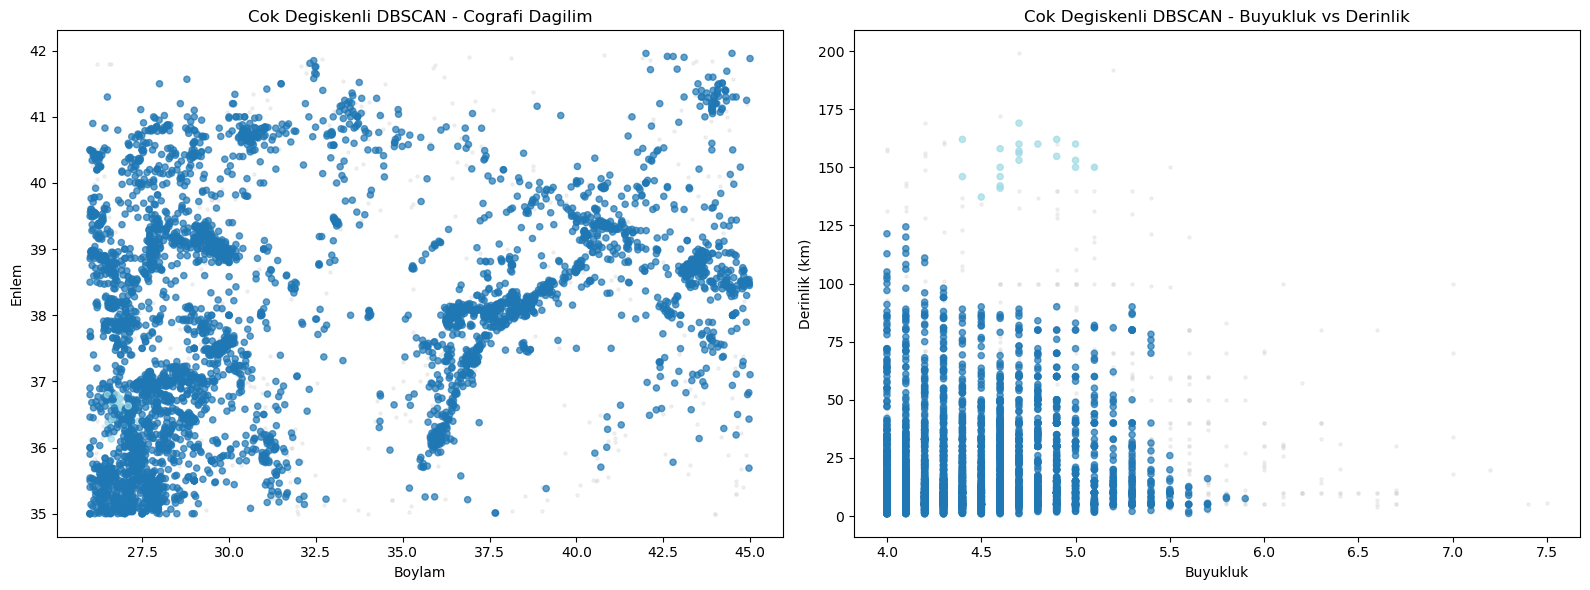

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

noise_mask = clustering_data['Multi_Cluster'] == -1
axes[0].scatter(clustering_data.loc[noise_mask, 'Longitude'], 
                clustering_data.loc[noise_mask, 'Latitude'],
                c='lightgray', s=5, alpha=0.3, label='Gurultu')

clustered_mask = clustering_data['Multi_Cluster'] != -1
scatter = axes[0].scatter(clustering_data.loc[clustered_mask, 'Longitude'], 
                          clustering_data.loc[clustered_mask, 'Latitude'],
                          c=clustering_data.loc[clustered_mask, 'Multi_Cluster'],
                          cmap='tab20', s=20, alpha=0.7)
axes[0].set_xlabel('Boylam')
axes[0].set_ylabel('Enlem')
axes[0].set_title('Cok Degiskenli DBSCAN - Cografi Dagilim')

axes[1].scatter(clustering_data.loc[noise_mask, 'Magnitude'], 
                clustering_data.loc[noise_mask, 'Depth'],
                c='lightgray', s=5, alpha=0.3, label='Gurultu')
axes[1].scatter(clustering_data.loc[clustered_mask, 'Magnitude'], 
                clustering_data.loc[clustered_mask, 'Depth'],
                c=clustering_data.loc[clustered_mask, 'Multi_Cluster'],
                cmap='tab20', s=20, alpha=0.7)
axes[1].set_xlabel('Buyukluk')
axes[1].set_ylabel('Derinlik (km)')
axes[1].set_title('Cok Degiskenli DBSCAN - Buyukluk vs Derinlik')

plt.tight_layout()
plt.savefig('../outputs/11_dbscan_multivariate_clusters.png', dpi=150)
plt.show()

In [72]:
multi_cluster_stats = clustering_data[clustering_data['Multi_Cluster'] != -1].groupby('Multi_Cluster').agg({
    'Latitude': 'mean',
    'Longitude': 'mean',
    'Magnitude': ['count', 'mean', 'std', 'max'],
    'Depth': ['mean', 'std']
}).round(3)
multi_cluster_stats.columns = ['Ort_Enlem', 'Ort_Boylam', 'Deprem_Sayisi', 'Ort_Buyukluk', 
                               'Std_Buyukluk', 'Max_Buyukluk', 'Ort_Derinlik', 'Std_Derinlik']
multi_cluster_stats = multi_cluster_stats.sort_values('Deprem_Sayisi', ascending=False)

print("Cok Degiskenli Kume Istatistikleri:")
multi_cluster_stats.head(15)

Cok Degiskenli Kume Istatistikleri:


,Ort_Enlem,Ort_Boylam,Deprem_Sayisi,Ort_Buyukluk,Std_Buyukluk,Max_Buyukluk,Ort_Derinlik,Std_Derinlik
Multi_Cluster,,,,,,,,
0,37.945,32.415,4674,4.411,0.365,5.9,17.271,18.449
1,36.579,26.811,20,4.725,0.202,5.1,153.345,8.128


## 8. Sismik Oruntuler

In [73]:
kg_sorted = kg.sort_values('Date').copy()
kg_sorted['Days_Since_Last'] = kg_sorted['Date'].diff().dt.days

print("Depremler Arasi Sure Istatistikleri:")
print(f"Ortalama: {kg_sorted['Days_Since_Last'].mean():.2f} gun")
print(f"Medyan: {kg_sorted['Days_Since_Last'].median():.2f} gun")
print(f"Standart Sapma: {kg_sorted['Days_Since_Last'].std():.2f} gun")

Depremler Arasi Sure Istatistikleri:
Ortalama: 7.58 gun
Medyan: 2.00 gun
Standart Sapma: 43.32 gun


In [74]:
major_earthquakes = kg[kg['Magnitude'] >= 6.0].copy()
print(f"Buyuk Deprem Sayisi (M >= 6.0): {len(major_earthquakes)}")

aftershock_windows = [1, 7, 30]
print("\nArtci Deprem Analizi:")

for _, major_eq in major_earthquakes.iterrows():
    for window in aftershock_windows:
        start = major_eq['Date']
        end = start + pd.Timedelta(days=window)
        aftershocks = kg[(kg['Date'] > start) & 
                         (kg['Date'] <= end) &
                         (abs(kg['Latitude'] - major_eq['Latitude']) < 1) &
                         (abs(kg['Longitude'] - major_eq['Longitude']) < 1)]
        if len(aftershocks) > 0 and window == 7:
            print(f"{major_eq['Date'].strftime('%Y-%m-%d')} M{major_eq['Magnitude']:.1f} - {len(aftershocks)} artci ({window} gun icinde)")

Buyuk Deprem Sayisi (M >= 6.0): 63

Artci Deprem Analizi:
2023-02-20 M6.4 - 5 artci (7 gun icinde)
2023-02-06 M6.0 - 61 artci (7 gun icinde)
2023-02-06 M7.4 - 91 artci (7 gun icinde)
2023-02-06 M6.6 - 89 artci (7 gun icinde)
2023-02-06 M7.5 - 92 artci (7 gun icinde)
2022-11-23 M6.1 - 1 artci (7 gun icinde)
2021-10-12 M6.3 - 1 artci (7 gun icinde)
2020-10-30 M6.7 - 17 artci (7 gun icinde)
2020-01-24 M6.7 - 11 artci (7 gun icinde)
2017-07-20 M6.6 - 19 artci (7 gun icinde)
2017-06-12 M6.3 - 9 artci (7 gun icinde)
2015-04-16 M6.1 - 8 artci (7 gun icinde)
2012-06-10 M6.0 - 7 artci (7 gun icinde)
2011-10-23 M6.7 - 62 artci (7 gun icinde)
2010-03-08 M6.0 - 4 artci (7 gun icinde)
1970-03-28 M7.0 - 51 artci (7 gun icinde)
1968-12-05 M6.1 - 1 artci (7 gun icinde)
1968-09-03 M6.1 - 2 artci (7 gun icinde)
1967-07-22 M6.3 - 13 artci (7 gun icinde)
1966-08-19 M6.1 - 10 artci (7 gun icinde)
1964-10-06 M7.0 - 1 artci (7 gun icinde)
1963-09-18 M6.0 - 1 artci (7 gun icinde)
1957-05-26 M6.6 - 13 artci (7

In [75]:
depth_bins = [0, 10, 30, 70, 150, 300, 700]
depth_labels = ['Cok Sik (0-10)', 'Sik (10-30)', 'Orta (30-70)', 
                'Derin (70-150)', 'Cok Derin (150-300)', 'Ultra Derin (300+)']

kg['Depth_Category'] = pd.cut(kg['Depth'], bins=depth_bins, labels=depth_labels[:len(depth_bins)-1])

depth_mag_stats = kg.groupby('Depth_Category', observed=True).agg({
    'Magnitude': ['count', 'mean', 'std', 'max']
}).round(2)
depth_mag_stats.columns = ['Deprem_Sayisi', 'Ort_Buyukluk', 'Std_Buyukluk', 'Max_Buyukluk']

print("Derinlik Kategorisine Gore Buyukluk Analizi:")
depth_mag_stats

Derinlik Kategorisine Gore Buyukluk Analizi:


,Deprem_Sayisi,Ort_Buyukluk,Std_Buyukluk,Max_Buyukluk
Depth_Category,,,,
Cok Sik (0-10),2689,4.40,0.45,7.5
Sik (10-30),1403,4.53,0.45,7.2
Orta (30-70),867,4.63,0.45,7.0
Derin (70-150),267,4.62,0.51,7.0
Cok Derin (150-300),23,4.60,0.34,5.2


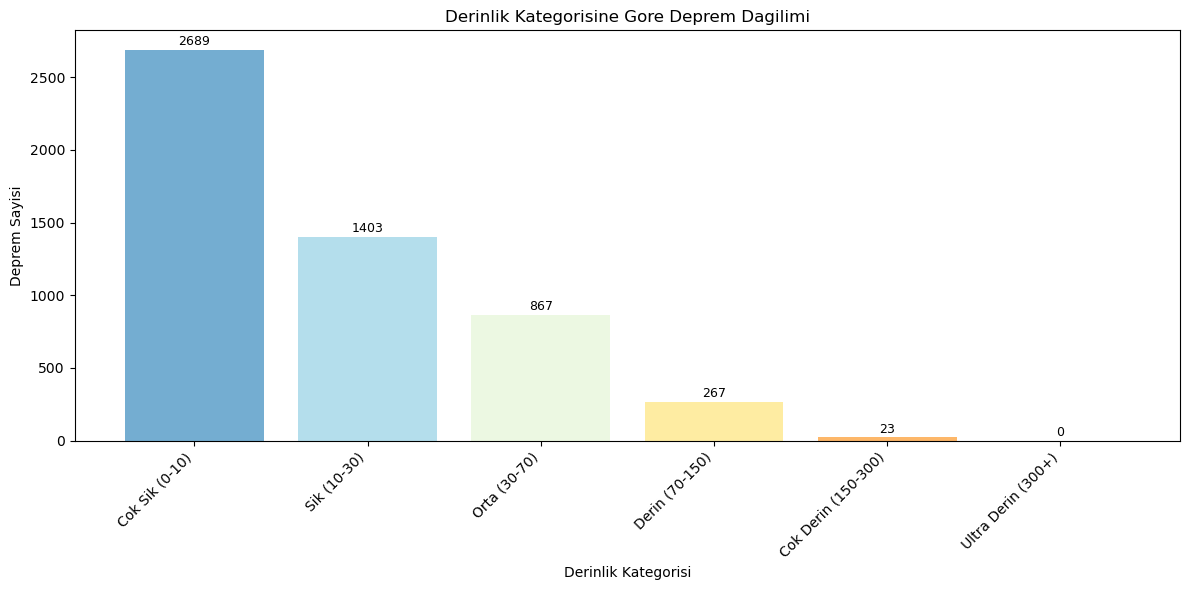

In [76]:
fig, ax = plt.subplots(figsize=(12, 6))

depth_counts = kg['Depth_Category'].value_counts().sort_index()
colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(depth_counts)))

bars = ax.bar(range(len(depth_counts)), depth_counts.values, color=colors)
ax.set_xticks(range(len(depth_counts)))
ax.set_xticklabels(depth_counts.index, rotation=45, ha='right')
ax.set_xlabel('Derinlik Kategorisi')
ax.set_ylabel('Deprem Sayisi')
ax.set_title('Derinlik Kategorisine Gore Deprem Dagilimi')

for bar, count in zip(bars, depth_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
            str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/12_depth_category_distribution.png', dpi=150)
plt.show()

## 9. Sonuc Ozeti

In [77]:
print("="*60)
print("ANALIZ OZETI")
print("="*60)
print(f"\n1. VERI SETI")
print(f"   - Toplam Deprem Sayisi (M>=4): {len(kg)}")
print(f"   - Zaman Araligi: {kg['Date'].min().strftime('%Y')} - {kg['Date'].max().strftime('%Y')}")
print(f"   - Buyukluk Araligi: {kg['Magnitude'].min():.1f} - {kg['Magnitude'].max():.1f}")

print(f"\n2. BUYUKLUK DAGILIMI")
print(f"   - Ortalama: {kg['Magnitude'].mean():.2f}")
print(f"   - Standart Sapma: {kg['Magnitude'].std():.2f}")
print(f"   - Major Deprem (M>=7): {len(kg[kg['Magnitude']>=7])}")

print(f"\n3. DERINLIK DAGILIMI")
print(f"   - Ortalama: {kg['Depth'].mean():.2f} km")
print(f"   - Medyan: {kg['Depth'].median():.2f} km")

print(f"\n4. KORELASYONLAR")
print(f"   - Buyukluk-Derinlik: {corr_coef:.4f}")
if len(merged_post1960) >= 3:
    print(f"   - Buyukluk-Olum (1960+): {corr_mag_death:.4f}")

print(f"\n5. DBSCAN KUMELEME")
print(f"   - Cografi Kume Sayisi: {n_clusters_geo}")
print(f"   - Cok Degiskenli Kume Sayisi: {n_clusters_multi}")

print(f"\n6. EN AKTIF BOLGELER")
for i, (region, row) in enumerate(location_stats.head(5).iterrows()):
    print(f"   {i+1}. {region}: {int(row['Deprem_Sayisi'])} deprem")

ANALIZ OZETI

1. VERI SETI
   - Toplam Deprem Sayisi (M>=4): 5249
   - Zaman Araligi: 1915 - 2023
   - Buyukluk Araligi: 4.0 - 7.5

2. BUYUKLUK DAGILIMI
   - Ortalama: 4.48
   - Standart Sapma: 0.46
   - Major Deprem (M>=7): 7

3. DERINLIK DAGILIMI
   - Ortalama: 21.28 km
   - Medyan: 10.00 km

4. KORELASYONLAR
   - Buyukluk-Derinlik: 0.1818
   - Buyukluk-Olum (1960+): 0.4547

5. DBSCAN KUMELEME
   - Cografi Kume Sayisi: 10
   - Cok Degiskenli Kume Sayisi: 2

6. EN AKTIF BOLGELER
   1. AKDENIZ: 1005 deprem
   2. VAN: 296 deprem
   3. KAHRAMANMARAS: 280 deprem
   4. MUGLA: 207 deprem
   5. MALATYA: 179 deprem


In [78]:
clustering_data.to_csv('../outputs/clustering_results.csv', index=False)
cluster_stats.to_csv('../outputs/geo_cluster_statistics.csv')
multi_cluster_stats.to_csv('../outputs/multi_cluster_statistics.csv')
location_stats.to_csv('../outputs/regional_statistics.csv')
frequent_regions.to_csv('../outputs/high_risk_regions.csv')

print("Sonuclar kaydedildi.")

Sonuclar kaydedildi.
